In [1]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_log
from skimage.restoration import denoise_tv_chambolle, denoise_wavelet, denoise_bilateral
from skimage.filters import threshold_niblack
from skimage.util import img_as_float, img_as_ubyte, img_as_uint
from skimage.morphology import reconstruction
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.morphology import disk, diamond, square
from skimage.filters import rank
from skimage.filters import threshold_mean
from skimage.morphology import erosion, dilation, opening, closing, binary_opening, binary_closing, binary_dilation, binary_erosion

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

import skimage
print("skimage: " + skimage.__version__)  # Must be greater then 0.14 for Chain Vesa

skimage: 0.14dev


# Corner detection in green region (Harris corner detector )

(-0.5, 461.5, 215.5, -0.5)

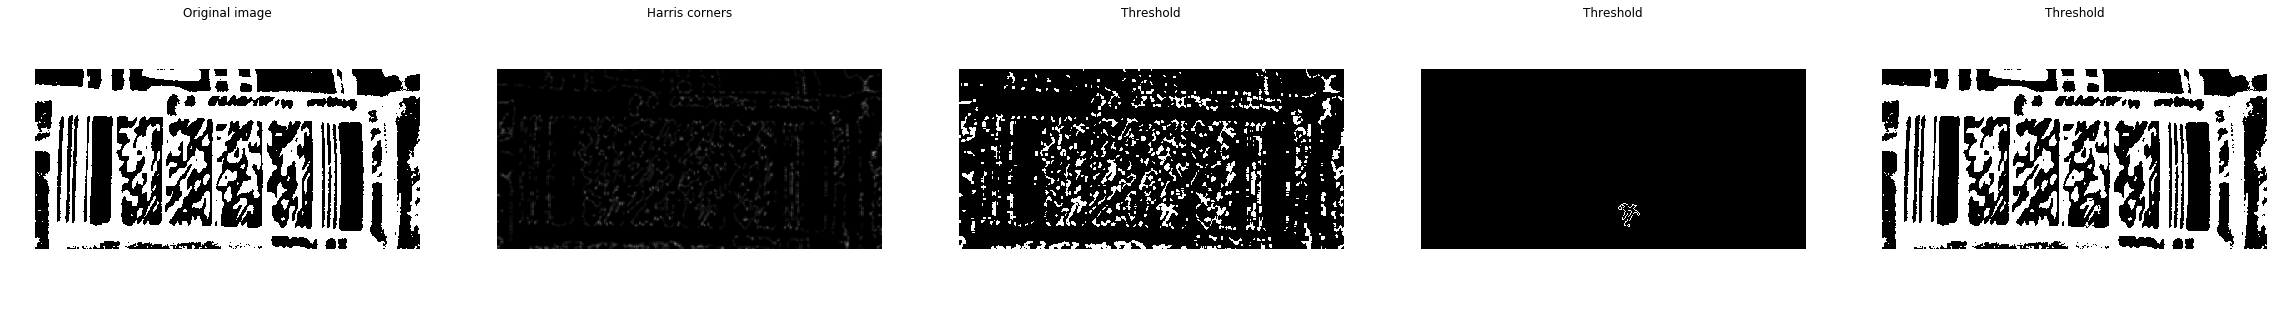

In [27]:
well = cv2.imread('test_data/maskedFinal720/_1521113532166_capture.png')[252:252+216, 523:523+462]
well = cv2.cvtColor(well, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
well = clahe.apply(well)
well = cv2.adaptiveThreshold(well, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)

fig, ax = plt.subplots(1, 5, figsize=(40, 5), sharex=True, sharey=True)
# ax = ax.ravel()

ax[0].imshow(cv2.cvtColor(well, cv2.COLOR_GRAY2RGB))
ax[0].set_title('Original image')
ax[0].axis('off')

harris = cv2.cornerHarris(well,4, 1,0.00)

ax[1].imshow(cv2.cvtColor(harris, cv2.COLOR_GRAY2RGB))
ax[1].set_title('Harris corners')
ax[1].axis('off')

x, thr = cv2.threshold(harris, 0.1 * harris.max(), 255, cv2.THRESH_BINARY)
thr = thr.astype('uint8')

ax[2].imshow(cv2.cvtColor(thr, cv2.COLOR_GRAY2RGB))
ax[2].set_title('Threshold')
ax[2].axis('off')

dst, contours, hierarchy = cv2.findContours(thr.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
areas = list(map(lambda x: cv2.contourArea(cv2.convexHull(x)), contours))
max_i = np.argmax(areas)
d = cv2.drawContours(np.zeros_like(thr), contours, max_i, 255, 1)

ax[3].imshow(cv2.cvtColor(d, cv2.COLOR_GRAY2RGB))
ax[3].set_title('Threshold')
ax[3].axis('off')

rect =cv2.minAreaRect(contours[max_i])
box = cv2.boxPoints(rect)
box = np.int0(box)
e = cv2.drawContours(well,[box],0,1,1)

ax[4].imshow(cv2.cvtColor(e, cv2.COLOR_GRAY2RGB))
ax[4].set_title('Threshold')
ax[4].axis('off')

# Square and lines detection in green region (Approximate each contour)

In [2]:
class ShapeDetector:
    def __init__(self):
        pass

    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        color = (0, 0, 0)
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)

        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
            color = (0, 255, 0)

        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)

            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
            color = (0, 0, 255)

        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"
            color = (255, 0, 0)

        elif len(approx) < 8:
            shape = "multigon"
            color = (0,255,255)
            
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
            color = (255,255,0)

        # return the name of the shape
        return shape, color

(-0.5, 461.5, 215.5, -0.5)

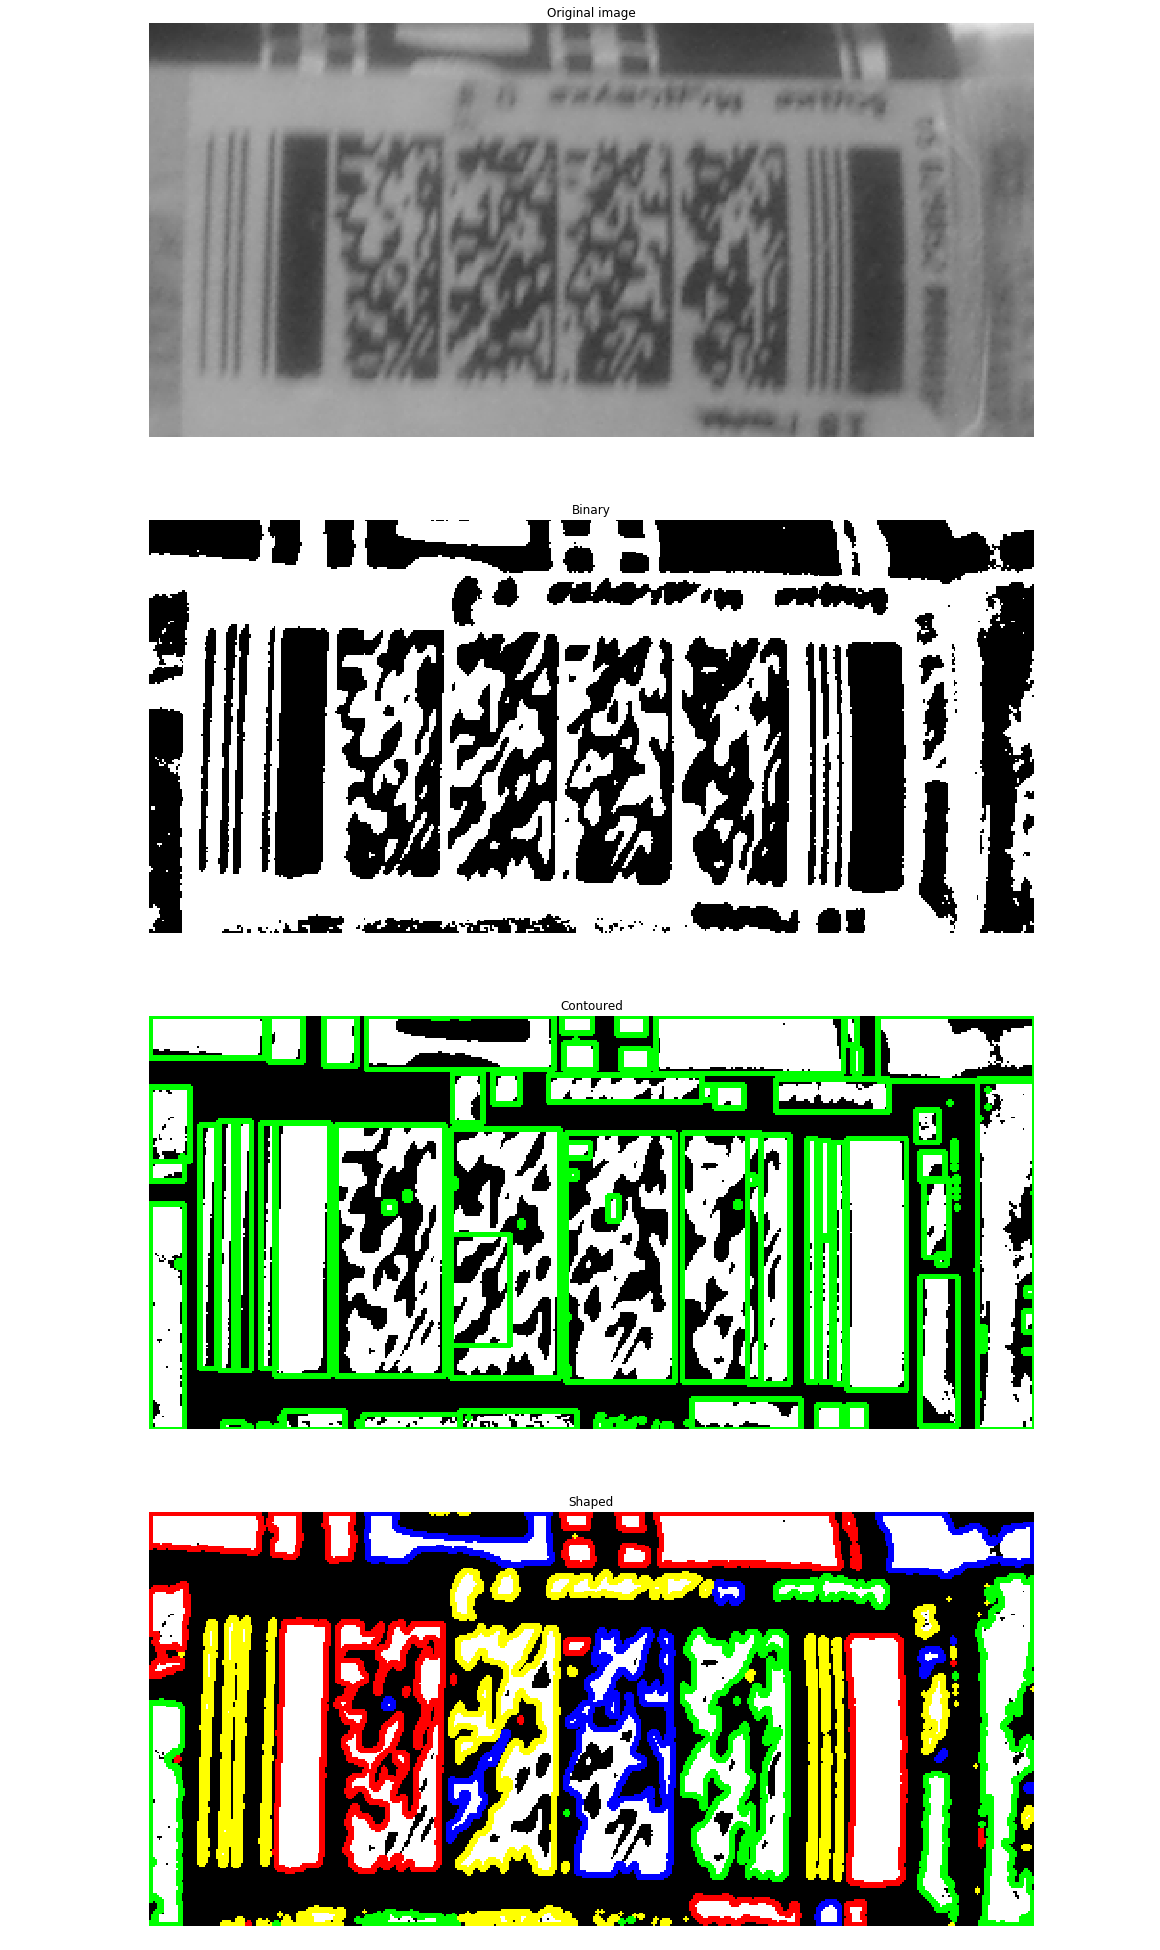

In [60]:
well = cv2.imread('test_data/maskedFinal720/_1521113532166_capture.png')[252:252+216, 523:523+462]
well = cv2.cvtColor(well, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(4, 1, figsize=(20, 35), sharex=True, sharey=True)
# ax = ax.ravel()

ax[0].imshow(cv2.cvtColor(well, cv2.COLOR_GRAY2RGB))
ax[0].set_title('Original image')
ax[0].axis('off')

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clh = clahe.apply(well)
thresh = cv2.adaptiveThreshold(clh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 115, 1)

ax[1].imshow(cv2.cvtColor(thres, cv2.COLOR_GRAY2RGB))
ax[1].set_title('Binary')
ax[1].axis('off')

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
sd = ShapeDetector()
contours = np.dstack([thresh.copy()] * 3)
shapes = np.dstack([thresh.copy()] * 3)

# loop over the contours
for c in cnts:
    # draw contours
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(contours, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    shape, color = sd.detect(c)

    cv2.drawContours(shapes, [c], -1, color, 2)
    # cv2.putText(shapes, shape, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

ax[2].imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))
ax[2].set_title('Contoured')
ax[2].axis('off')

ax[3].imshow(cv2.cvtColor(shapes, cv2.COLOR_BGR2RGB))
ax[3].set_title('Shaped')
ax[3].axis('off')

## Success. As we see rectangles(red) succesfully detected

### Test it on dataset

100%|██████████| 21/21 [00:02<00:00,  7.79it/s]


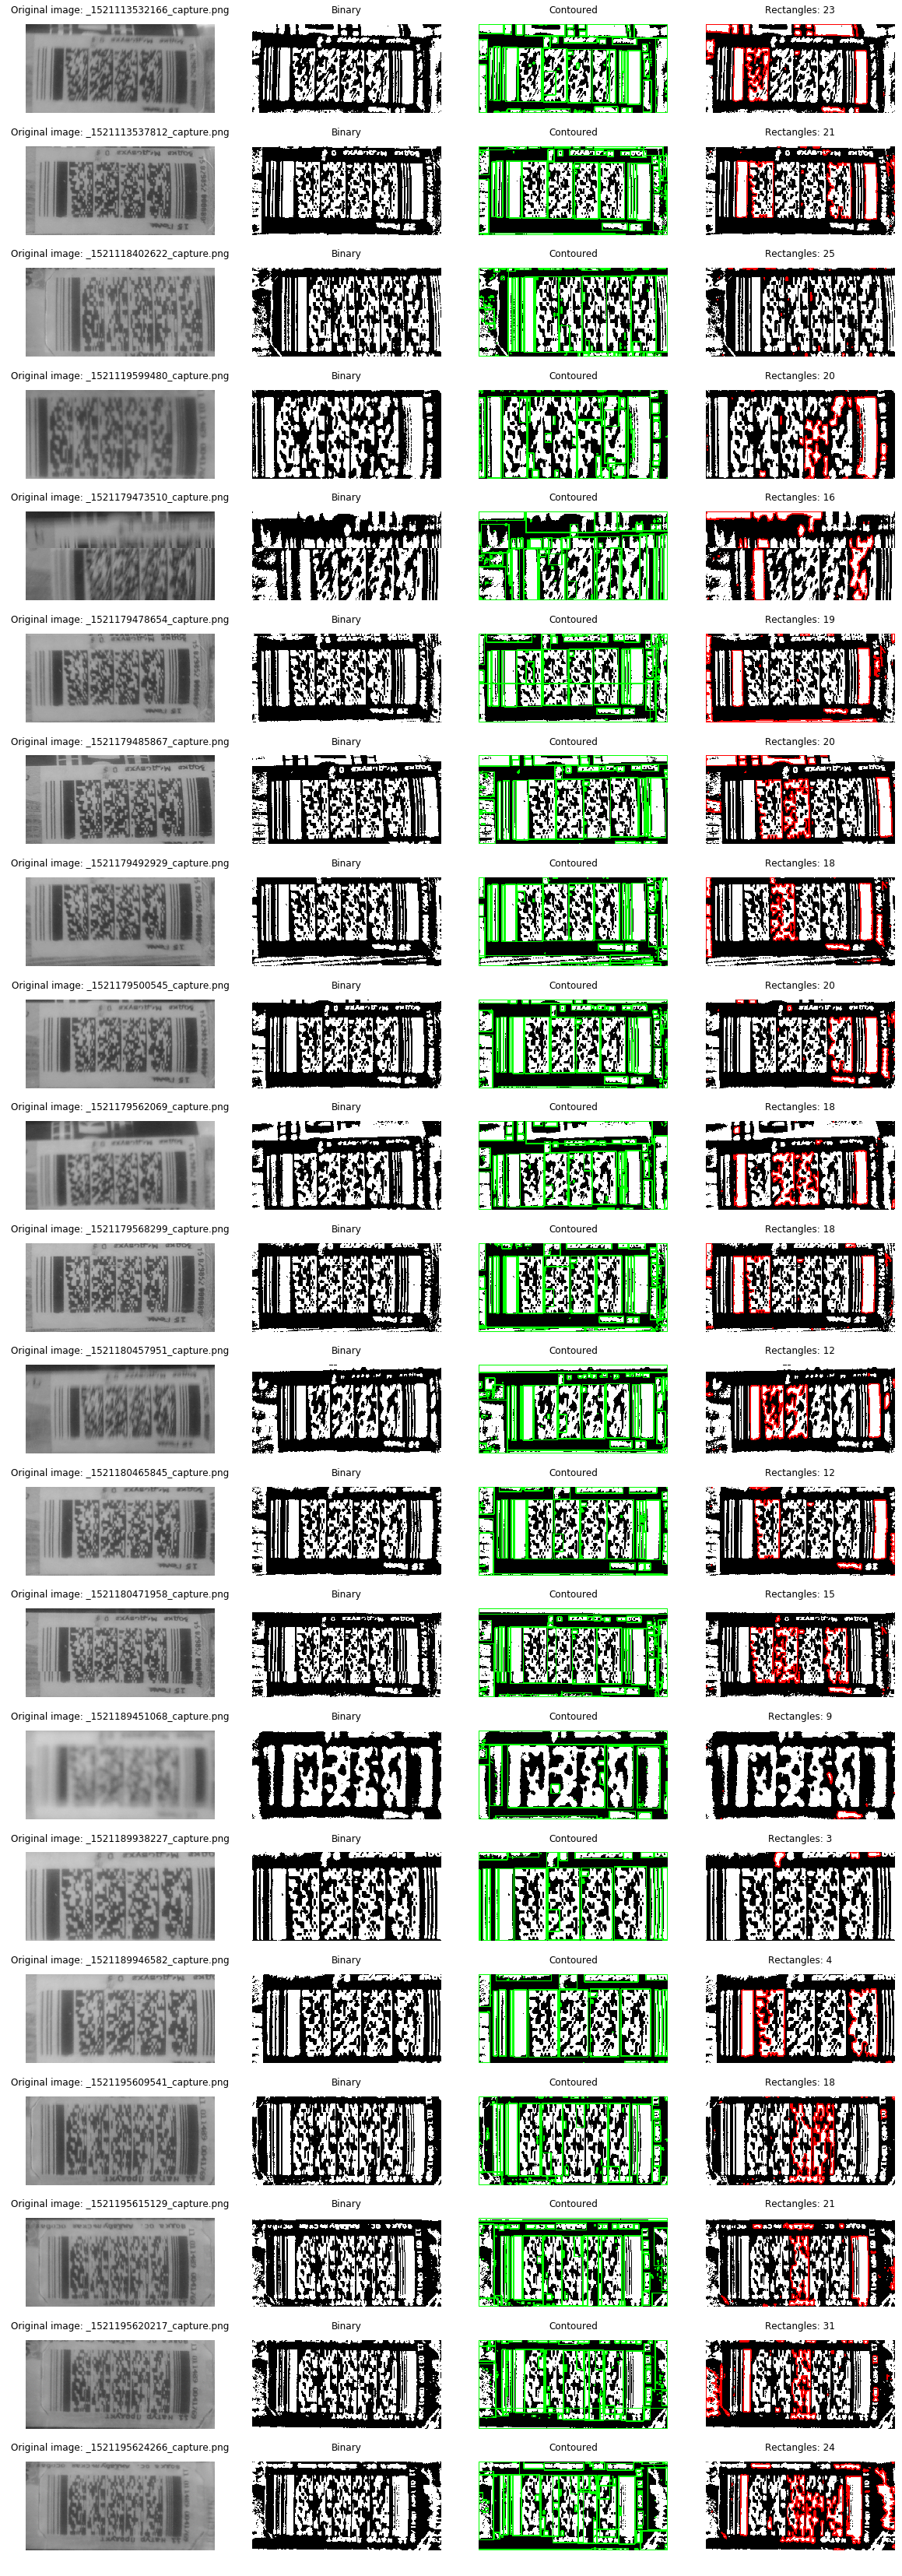

In [78]:
DIR = 'test_data/maskedFinal720'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".PNG") or name.endswith(".png"))])
current_file_index = 0
fig, ax = plt.subplots(filescount, 4, figsize=(20, 60), sharex=True, sharey=True)

for filename in tqdm(os.listdir(DIR)):
    if not (filename.endswith(".PNG") or filename.endswith(".png")):
        continue
        
    file_src = cv2.imread(os.path.join(DIR, filename))[252:252+216, 523:523+462]
    
    well = cv2.cvtColor(file_src, cv2.COLOR_BGR2GRAY)

    ax[current_file_index][0].imshow(cv2.cvtColor(well, cv2.COLOR_GRAY2RGB))
    ax[current_file_index][0].set_title('Original image: ' + filename)
    ax[current_file_index][0].axis('off')

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clh = clahe.apply(well)
    thresh = cv2.adaptiveThreshold(clh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 115, 1)

    ax[current_file_index][1].imshow(cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB))
    ax[current_file_index][1].set_title('Binary')
    ax[current_file_index][1].axis('off')

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    sd = ShapeDetector()
    contours = np.dstack([thresh.copy()] * 3)
    shapes = np.dstack([thresh.copy()] * 3)
    
    rectangles_count = 0

    # loop over the contours
    for c in cnts:
        # draw contours
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

        shape, color = sd.detect(c)
        
        if (shape == "rectangle"):
            rectangles_count += 1
            cv2.drawContours(shapes, [c], -1, color, 2)

    ax[current_file_index][2].imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))
    ax[current_file_index][2].set_title('Contoured')
    ax[current_file_index][2].axis('off')

    ax[current_file_index][3].imshow(cv2.cvtColor(shapes, cv2.COLOR_BGR2RGB))
    ax[current_file_index][3].set_title('Rectangles: ' + str(rectangles_count))
    ax[current_file_index][3].axis('off')
    
    current_file_index += 1

# Test some fails

(-0.5, 461.5, 215.5, -0.5)

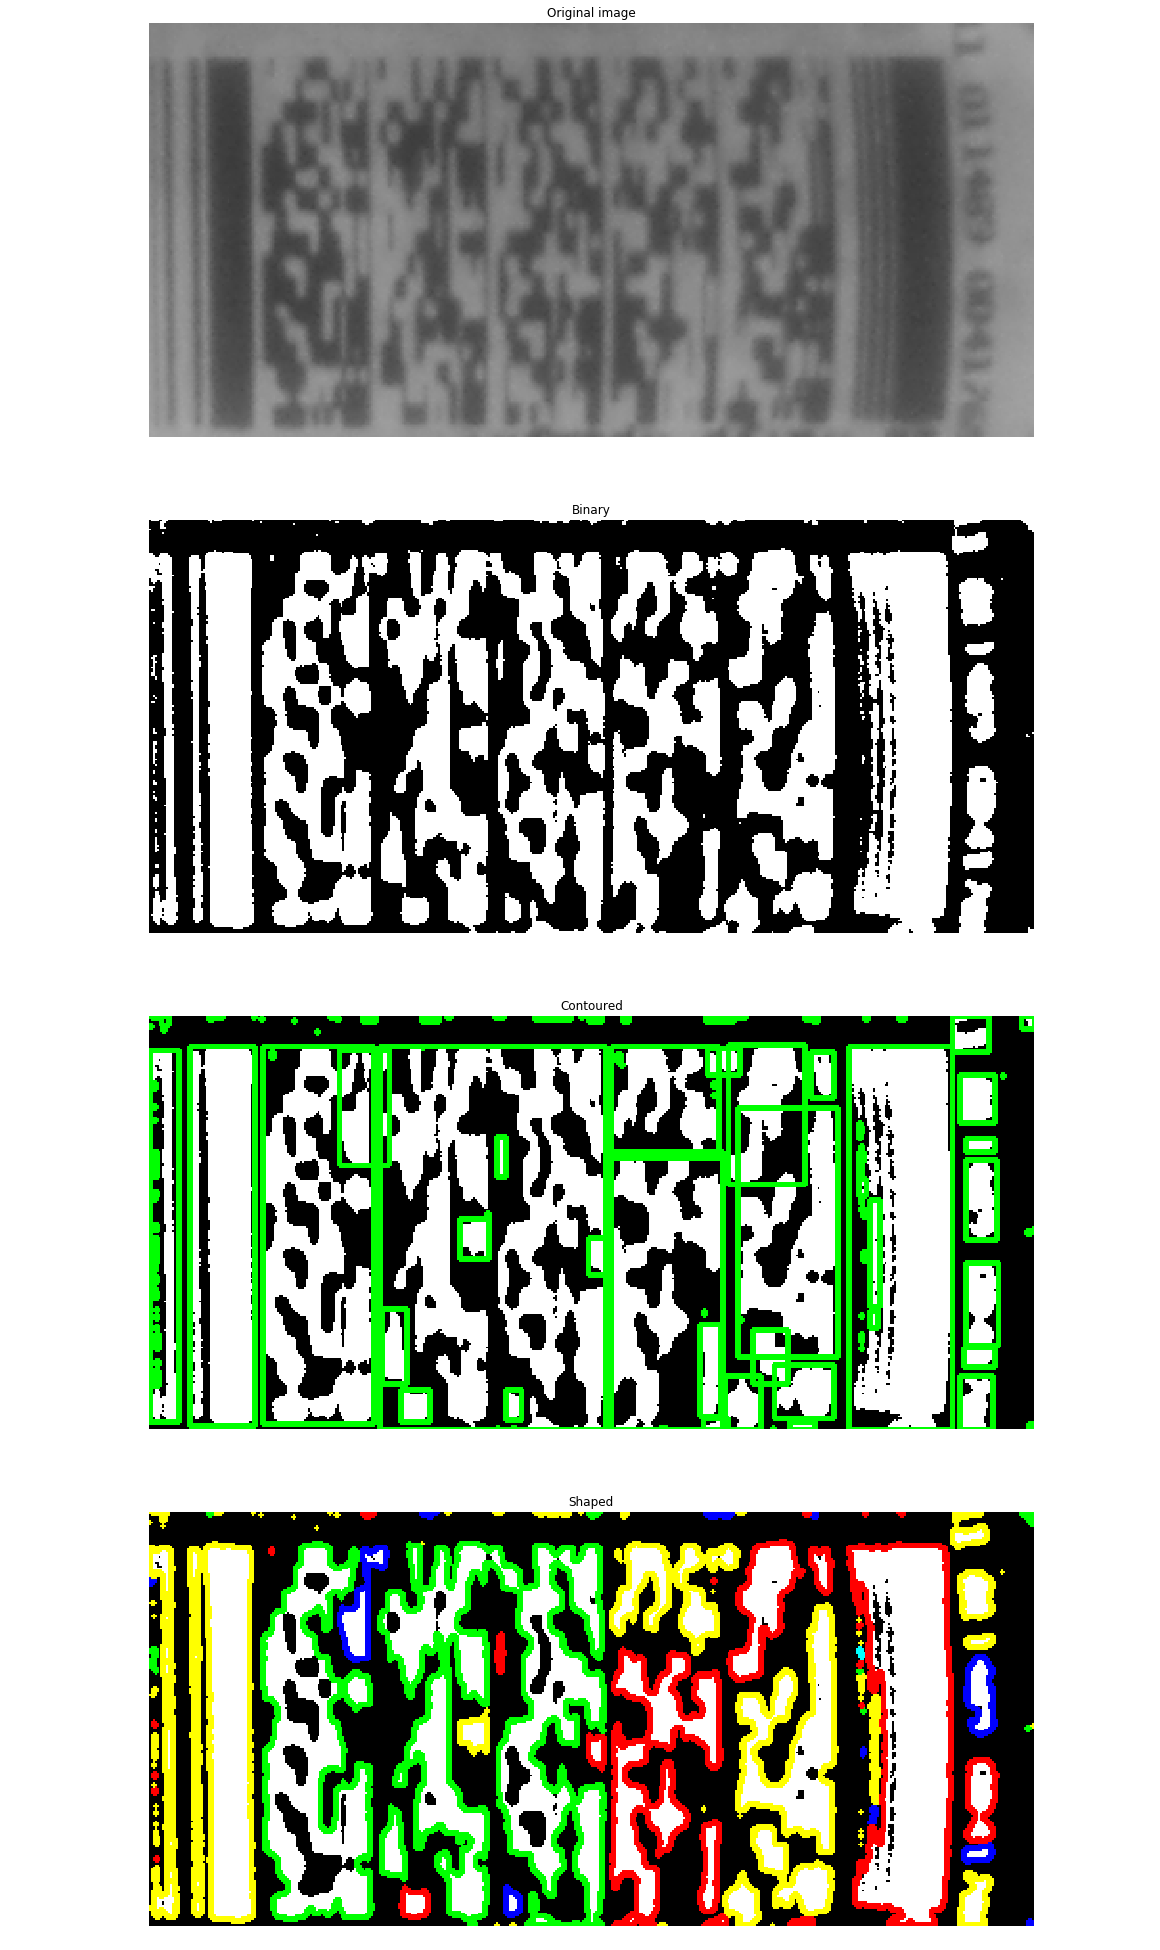

In [3]:
well = cv2.imread('test_data/maskedFinal720/_1521119599480_capture.png')[252:252+216, 523:523+462]
well = cv2.cvtColor(well, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(4, 1, figsize=(20, 35), sharex=True, sharey=True)
# ax = ax.ravel()

ax[0].imshow(cv2.cvtColor(well, cv2.COLOR_GRAY2RGB))
ax[0].set_title('Original image')
ax[0].axis('off')

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clh = clahe.apply(well)
thresh = cv2.adaptiveThreshold(clh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 115, 1)

ax[1].imshow(cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB))
ax[1].set_title('Binary')
ax[1].axis('off')

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
sd = ShapeDetector()
contours = np.dstack([thresh.copy()] * 3)
shapes = np.dstack([thresh.copy()] * 3)

# loop over the contours
for c in cnts:
    # draw contours
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(contours, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    shape, color = sd.detect(c)

    cv2.drawContours(shapes, [c], -1, color, 2)
    # cv2.putText(shapes, shape, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

ax[2].imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))
ax[2].set_title('Contoured')
ax[2].axis('off')

ax[3].imshow(cv2.cvtColor(shapes, cv2.COLOR_BGR2RGB))
ax[3].set_title('Shaped')
ax[3].axis('off')

### It is not appropriate for us to simply use the approximation of contours because of the inaccurate morphology in the image. So we will carry out an efristic analysis on the perimeter and covenant area